In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [3]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [4]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [5]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [6]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [7]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [8]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


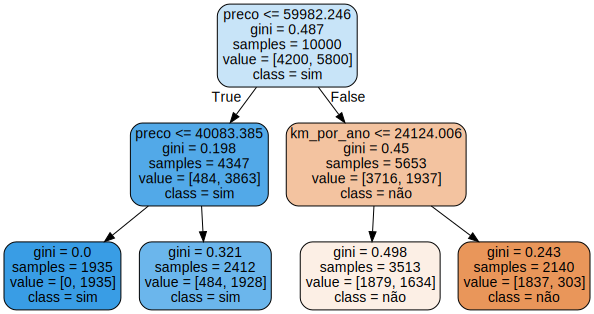

In [9]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(
    modelo, 
    out_file=None, 
    filled=True, 
    rounded=True, 
    class_names=['não', 'sim'],
    feature_names=features
)
graph = graphviz.Source(dot_data)
graph

In [10]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


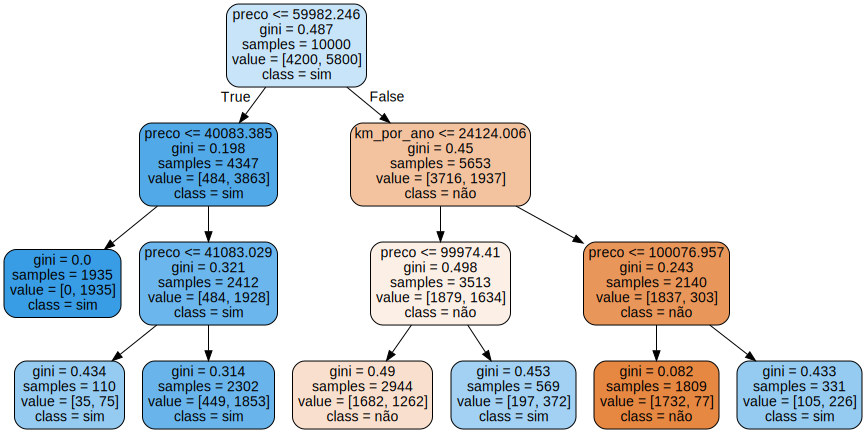

In [11]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(
    modelo, 
    out_file=None, 
    filled=True, 
    rounded=True, 
    class_names=['não', 'sim'],
    feature_names=features
)
graph = graphviz.Source(dot_data)
graph

In [12]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


# Explorando hiper parâmetros em 1 dimensão

In [13]:
def roda_arvore_de_desicao(max_depth):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth = max_depth)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = round(results["test_score"].mean() * 100, 2)
    test_score = round(results["train_score"].mean() * 100, 2)
    print(f'Arvore max_depth = {max_depth}, treino = {test_score}, teste = {train_score}')
    tabela = [max_depth, train_score, test_score]
    return tabela
    

resultados = [roda_arvore_de_desicao(i) for i in range(2, 25)]
resultados = pd.DataFrame(resultados, columns=['max_depth', 'train', 'test'])
resultados.head()

Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.5, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Arvore max_depth = 20, treino = 91.32, teste = 74.22
Ar

,max_depth,train,test
0,2,75.78,75.79
1,3,78.67,78.75
2,4,78.63,78.79
3,5,78.56,78.94
4,6,78.12,79.17


<AxesSubplot:xlabel='max_depth', ylabel='train'>

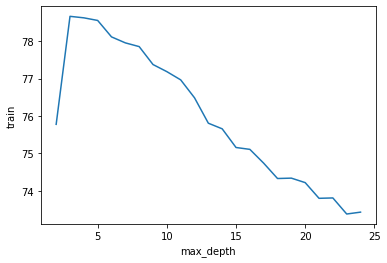

In [14]:
import seaborn as sns

sns.lineplot(data=resultados, x='max_depth', y='train')

# OVERFIT: Ficou 'perfeito' para o treino mas ruim para o teste

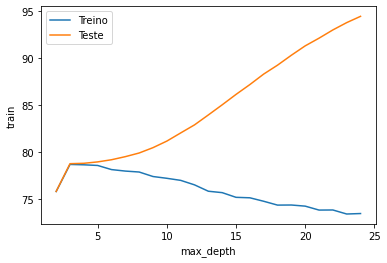

In [15]:
import matplotlib.pyplot as plt

sns.lineplot(data=resultados, x='max_depth', y='train')
sns.lineplot(data=resultados, x='max_depth', y='test')
plt.legend(['Treino', 'Teste'])

In [16]:
resultados.sort_values('test', ascending=False).head()

,max_depth,train,test
22,24,73.43,94.47
21,23,73.38,93.80
20,22,73.81,93.02
19,21,73.80,92.14
18,20,74.22,91.32


# Explorando hiper parâmetros em 2 dimensões

In [17]:
def roda_arvore_de_desicao(max_depth, min_samples_leaf):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    train_score = round(results["test_score"].mean() * 100, 2)
    test_score = round(results["train_score"].mean() * 100, 2)
    print(f'Arvore max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, treino = {test_score}, teste = {train_score}')
    tabela = [max_depth, min_samples_leaf, train_score, test_score]
    return tabela
    

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            tabela = roda_arvore_de_desicao(max_depth, min_samples_leaf)
            resultados.append(tabela)

    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

Arvore max_depth = 28, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 28, min_samples_leaf = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 29, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 29, min_samples_leaf = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 29, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 29, min_samples_leaf = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 30, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 30, min_samples_leaf = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 30, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 30, min_samples_leaf = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 31, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 31, min_samples_leaf = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 31, min_samples_leaf = 128, treino = 79.21, teste = 78.22
Arvore max_

,max_depth,min_samples_leaf,train,test
0,1,32,75.78,75.79
1,1,64,75.78,75.79
2,1,128,75.78,75.79
3,1,256,75.78,75.79
4,2,32,75.78,75.79


In [18]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
112,29,32,76.84,80.89
124,32,32,76.84,80.89
92,24,32,76.84,80.89
120,31,32,76.84,80.89
96,25,32,76.84,80.89


In [19]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,-0.027530,0.536594
min_samples_leaf,-2.780775e-16,1.000000e+00,0.350465,-0.409467
train,-2.753030e-02,3.504655e-01,1.000000,0.115960
test,5.365935e-01,-4.094665e-01,0.115960,1.000000


<AxesSubplot:>

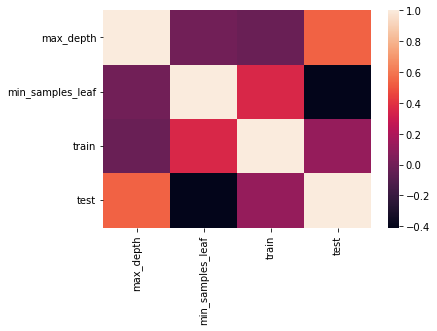

In [20]:
sns.heatmap(corr)

array([[<AxesSubplot:xlabel='max_depth', ylabel='max_depth'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='max_depth'>,
        <AxesSubplot:xlabel='train', ylabel='max_depth'>,
        <AxesSubplot:xlabel='test', ylabel='max_depth'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='train', ylabel='min_samples_leaf'>,
        <AxesSubplot:xlabel='test', ylabel='min_samples_leaf'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='train'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='train'>,
        <AxesSubplot:xlabel='train', ylabel='train'>,
        <AxesSubplot:xlabel='test', ylabel='train'>],
       [<AxesSubplot:xlabel='max_depth', ylabel='test'>,
        <AxesSubplot:xlabel='min_samples_leaf', ylabel='test'>,
        <AxesSubplot:xlabel='train', ylabel='test'>,
        <AxesSubplot:xlabel='test', ylabel='test'>]], dtype=object)

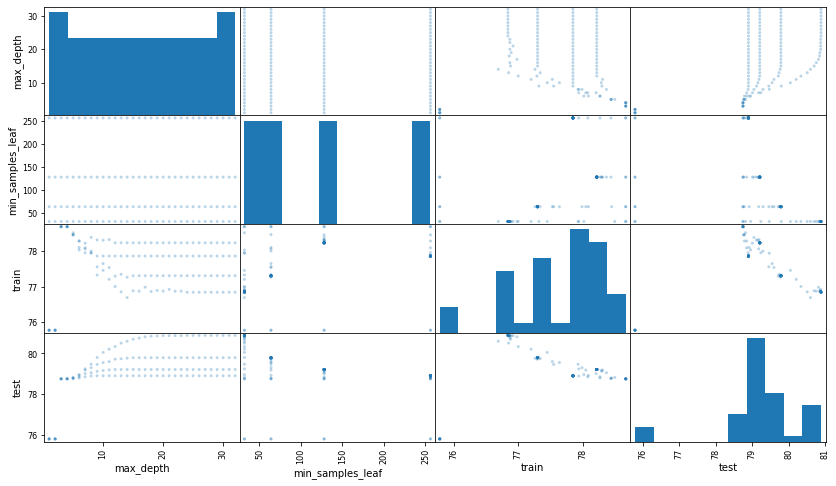

In [21]:
from pandas.plotting import scatter_matrix

scatter_matrix(resultados, figsize=(14, 8), alpha=0.3)

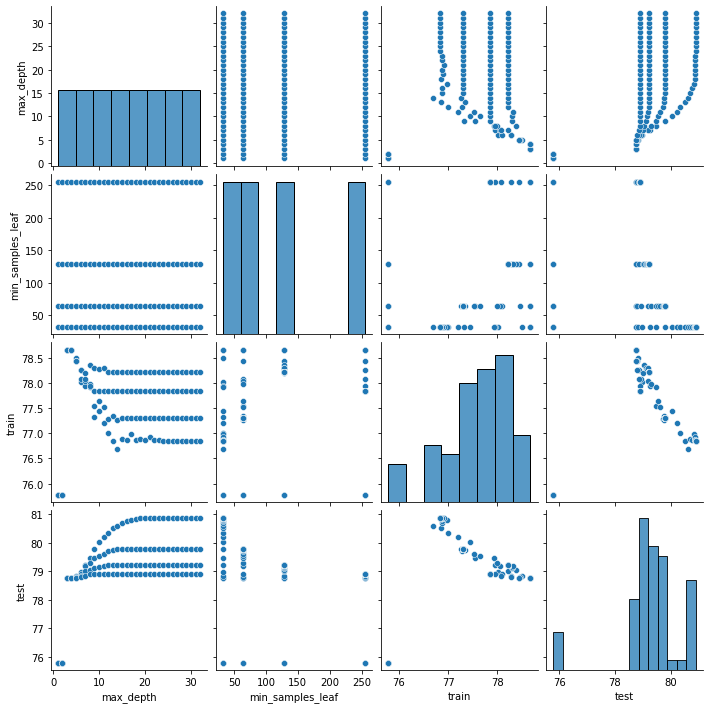

In [22]:
sns.pairplot(resultados)

<AxesSubplot:>

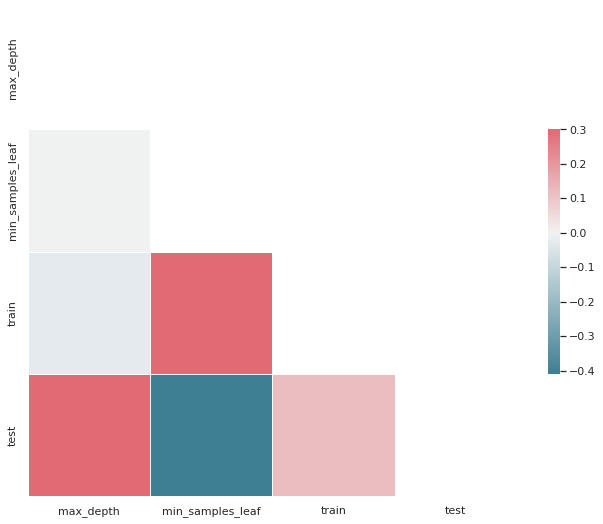

In [23]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [16, 32, 48, 64]:
            tabela = roda_arvore_de_desicao(max_depth, min_samples_leaf)
            resultados.append(tabela)

    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'train', 'test'])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 16, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 48, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 16, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 48, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 16, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 48, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 16, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min

Arvore max_depth = 28, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 28, min_samples_leaf = 48, treino = 80.15, teste = 77.27
Arvore max_depth = 28, min_samples_leaf = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 29, min_samples_leaf = 16, treino = 82.65, teste = 76.11
Arvore max_depth = 29, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 29, min_samples_leaf = 48, treino = 80.15, teste = 77.27
Arvore max_depth = 29, min_samples_leaf = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 30, min_samples_leaf = 16, treino = 82.65, teste = 76.13
Arvore max_depth = 30, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 30, min_samples_leaf = 48, treino = 80.15, teste = 77.27
Arvore max_depth = 30, min_samples_leaf = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 31, min_samples_leaf = 16, treino = 82.65, teste = 76.13
Arvore max_depth = 31, min_samples_leaf = 32, treino = 80.89, teste = 76.84
Arvore max_dept

,max_depth,min_samples_leaf,train,test
0,1,16,75.78,75.79
1,1,32,75.78,75.79
2,1,48,75.78,75.79
3,1,64,75.78,75.79
4,2,16,75.78,75.79


In [25]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-5.538795e-16,-0.33827,0.670002
min_samples_leaf,-5.538795e-16,1.000000e+00,0.36053,-0.415028
train,-3.382699e-01,3.605304e-01,1.00000,-0.217960
test,6.700024e-01,-4.150278e-01,-0.21796,1.000000


<AxesSubplot:>

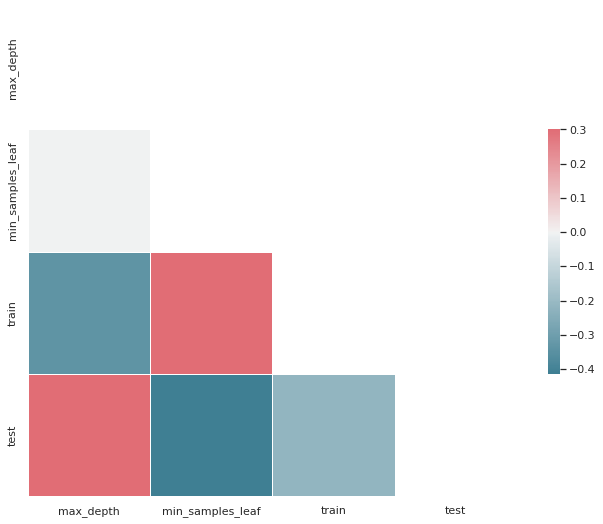

In [26]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,train,test
112,29,16,76.11,82.65
124,32,16,76.13,82.65
120,31,16,76.13,82.65
116,30,16,76.13,82.65
108,28,16,76.11,82.63


# Explorando 3 dimensões de hiper parâmetros

In [28]:
def roda_arvore_de_desicao(max_depth, min_samples_leaf, min_samples_split):
    SEED = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits = 10)
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
    results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
    fit_time = results['fit_time'].mean()
    score_time = results['score_time'].mean()
    train_score = round(results["test_score"].mean() * 100, 2)
    test_score = round(results["train_score"].mean() * 100, 2)
    print(f'Arvore max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, min_samples_split = {min_samples_split}, treino = {test_score}, teste = {train_score}')
    tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return tabela
    

def busca():
    resultados = []
    for max_depth in range(1, 33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 64, 128, 256]:
                tabela = roda_arvore_de_desicao(max_depth, min_samples_leaf, min_samples_split)
                resultados.append(tabela)

    resultados = pd.DataFrame(resultados, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 'train', 'test', 'fit_time', 'score_time'])
    return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, min_samples_split = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 32, min_samples_split = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 32, min_samples_split = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 32, min_samples_split = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, min_samples_split = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, min_samples_split = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, min_samples_split = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, min_samples_split = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, min_samples_split = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, min_samples_split = 64, treino = 75.79, teste = 75.78
Arvo

Arvore max_depth = 6, min_samples_leaf = 32, min_samples_split = 128, treino = 78.95, teste = 78.03
Arvore max_depth = 6, min_samples_leaf = 32, min_samples_split = 256, treino = 78.91, teste = 78.16
Arvore max_depth = 6, min_samples_leaf = 64, min_samples_split = 32, treino = 78.92, teste = 78.09
Arvore max_depth = 6, min_samples_leaf = 64, min_samples_split = 64, treino = 78.92, teste = 78.09
Arvore max_depth = 6, min_samples_leaf = 64, min_samples_split = 128, treino = 78.92, teste = 78.09
Arvore max_depth = 6, min_samples_leaf = 64, min_samples_split = 256, treino = 78.89, teste = 78.27
Arvore max_depth = 6, min_samples_leaf = 128, min_samples_split = 32, treino = 78.85, teste = 78.27
Arvore max_depth = 6, min_samples_leaf = 128, min_samples_split = 64, treino = 78.85, teste = 78.27
Arvore max_depth = 6, min_samples_leaf = 128, min_samples_split = 128, treino = 78.85, teste = 78.27
Arvore max_depth = 6, min_samples_leaf = 128, min_samples_split = 256, treino = 78.85, teste = 78.27


Arvore max_depth = 11, min_samples_leaf = 64, min_samples_split = 64, treino = 79.6, teste = 77.53
Arvore max_depth = 11, min_samples_leaf = 64, min_samples_split = 128, treino = 79.6, teste = 77.53
Arvore max_depth = 11, min_samples_leaf = 64, min_samples_split = 256, treino = 79.27, teste = 78.11
Arvore max_depth = 11, min_samples_leaf = 128, min_samples_split = 32, treino = 79.19, teste = 78.31
Arvore max_depth = 11, min_samples_leaf = 128, min_samples_split = 64, treino = 79.19, teste = 78.31
Arvore max_depth = 11, min_samples_leaf = 128, min_samples_split = 128, treino = 79.19, teste = 78.31
Arvore max_depth = 11, min_samples_leaf = 128, min_samples_split = 256, treino = 79.19, teste = 78.31
Arvore max_depth = 11, min_samples_leaf = 256, min_samples_split = 32, treino = 78.9, teste = 77.85
Arvore max_depth = 11, min_samples_leaf = 256, min_samples_split = 64, treino = 78.9, teste = 77.85
Arvore max_depth = 11, min_samples_leaf = 256, min_samples_split = 128, treino = 78.9, teste =

Arvore max_depth = 16, min_samples_leaf = 64, min_samples_split = 256, treino = 79.33, teste = 77.99
Arvore max_depth = 16, min_samples_leaf = 128, min_samples_split = 32, treino = 79.21, teste = 78.22
Arvore max_depth = 16, min_samples_leaf = 128, min_samples_split = 64, treino = 79.21, teste = 78.22
Arvore max_depth = 16, min_samples_leaf = 128, min_samples_split = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 16, min_samples_leaf = 128, min_samples_split = 256, treino = 79.21, teste = 78.22
Arvore max_depth = 16, min_samples_leaf = 256, min_samples_split = 32, treino = 78.9, teste = 77.85
Arvore max_depth = 16, min_samples_leaf = 256, min_samples_split = 64, treino = 78.9, teste = 77.85
Arvore max_depth = 16, min_samples_leaf = 256, min_samples_split = 128, treino = 78.9, teste = 77.85
Arvore max_depth = 16, min_samples_leaf = 256, min_samples_split = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 17, min_samples_leaf = 32, min_samples_split = 32, treino = 80.82, teste

Arvore max_depth = 21, min_samples_leaf = 128, min_samples_split = 64, treino = 79.21, teste = 78.22
Arvore max_depth = 21, min_samples_leaf = 128, min_samples_split = 128, treino = 79.21, teste = 78.22
Arvore max_depth = 21, min_samples_leaf = 128, min_samples_split = 256, treino = 79.21, teste = 78.22
Arvore max_depth = 21, min_samples_leaf = 256, min_samples_split = 32, treino = 78.9, teste = 77.85
Arvore max_depth = 21, min_samples_leaf = 256, min_samples_split = 64, treino = 78.9, teste = 77.85
Arvore max_depth = 21, min_samples_leaf = 256, min_samples_split = 128, treino = 78.9, teste = 77.85
Arvore max_depth = 21, min_samples_leaf = 256, min_samples_split = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 22, min_samples_leaf = 32, min_samples_split = 32, treino = 80.88, teste = 76.87
Arvore max_depth = 22, min_samples_leaf = 32, min_samples_split = 64, treino = 80.88, teste = 76.87
Arvore max_depth = 22, min_samples_leaf = 32, min_samples_split = 128, treino = 80.11, teste 

Arvore max_depth = 26, min_samples_leaf = 128, min_samples_split = 256, treino = 79.21, teste = 78.22
Arvore max_depth = 26, min_samples_leaf = 256, min_samples_split = 32, treino = 78.9, teste = 77.85
Arvore max_depth = 26, min_samples_leaf = 256, min_samples_split = 64, treino = 78.9, teste = 77.85
Arvore max_depth = 26, min_samples_leaf = 256, min_samples_split = 128, treino = 78.9, teste = 77.85
Arvore max_depth = 26, min_samples_leaf = 256, min_samples_split = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 27, min_samples_leaf = 32, min_samples_split = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 27, min_samples_leaf = 32, min_samples_split = 64, treino = 80.89, teste = 76.84
Arvore max_depth = 27, min_samples_leaf = 32, min_samples_split = 128, treino = 80.12, teste = 76.93
Arvore max_depth = 27, min_samples_leaf = 32, min_samples_split = 256, treino = 79.52, teste = 77.44
Arvore max_depth = 27, min_samples_leaf = 64, min_samples_split = 32, treino = 79.79, teste = 

Arvore max_depth = 31, min_samples_leaf = 256, min_samples_split = 64, treino = 78.9, teste = 77.85
Arvore max_depth = 31, min_samples_leaf = 256, min_samples_split = 128, treino = 78.9, teste = 77.85
Arvore max_depth = 31, min_samples_leaf = 256, min_samples_split = 256, treino = 78.9, teste = 77.85
Arvore max_depth = 32, min_samples_leaf = 32, min_samples_split = 32, treino = 80.89, teste = 76.84
Arvore max_depth = 32, min_samples_leaf = 32, min_samples_split = 64, treino = 80.89, teste = 76.84
Arvore max_depth = 32, min_samples_leaf = 32, min_samples_split = 128, treino = 80.12, teste = 76.93
Arvore max_depth = 32, min_samples_leaf = 32, min_samples_split = 256, treino = 79.52, teste = 77.44
Arvore max_depth = 32, min_samples_leaf = 64, min_samples_split = 32, treino = 79.79, teste = 77.3
Arvore max_depth = 32, min_samples_leaf = 64, min_samples_split = 64, treino = 79.79, teste = 77.3
Arvore max_depth = 32, min_samples_leaf = 64, min_samples_split = 128, treino = 79.79, teste = 77.

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.78,75.79,0.026993,0.010839
1,1,32,64,75.78,75.79,0.029975,0.011889
2,1,32,128,75.78,75.79,0.031430,0.011752
3,1,32,256,75.78,75.79,0.011220,0.002753
4,1,64,32,75.78,75.79,0.008394,0.002895


In [29]:
corr = resultados.corr()

<AxesSubplot:>

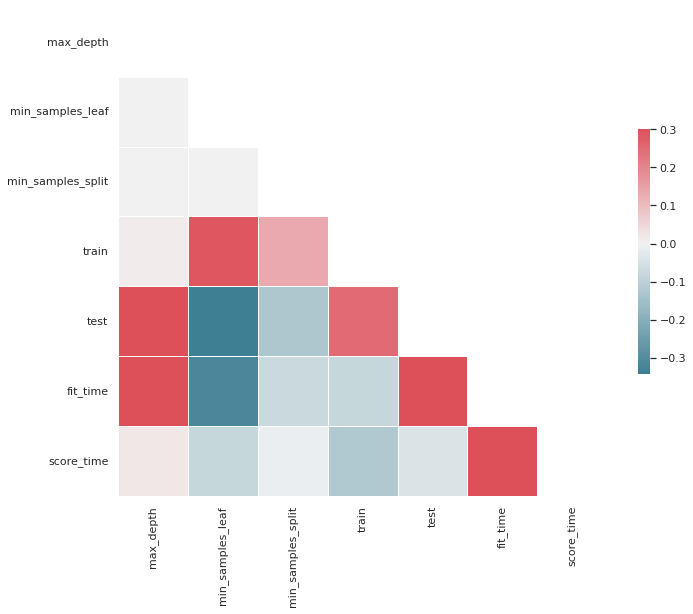

In [30]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [31]:
resultados.sort_values('test', ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
384,25,32,32,76.84,80.89,0.024427,0.002374
448,29,32,32,76.84,80.89,0.023713,0.002092
400,26,32,32,76.84,80.89,0.022967,0.001913
369,24,32,64,76.84,80.89,0.023225,0.002296
368,24,32,32,76.84,80.89,0.022291,0.001753


# Explorando espaço de hiper parâmetros com GridSearchCV

In [35]:
from sklearn.model_selection import GridSearchCV

SEE=301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=GroupKFold(n_splits=10))
busca.fit(x_azar, y_azar, groups=dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013758,0.007025,0.003367,0.004234,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.010619,0.001207,0.001873,0.000192,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.008211,0.000823,0.001479,0.000328,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.009616,0.002184,0.001982,0.000732,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.011532,0.003510,0.002893,0.002480,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [38]:
print(busca.best_params_)
print(round(busca.best_score_ * 100, 2))

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67


In [39]:
melhor = busca.best_estimator_
print(melhor)
print(melhor.criterion)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [43]:
from sklearn.metrics import accuracy_score

# Evitar essa abordagem pois estará sendo otimista

predicoes = melhor.predict(x_azar)
accuracy = accuracy_score(predicoes, y_azar)
print(f'Accuracy para os dados foi {round(accuracy * 100, 2)}%')

Accuracy para os dados foi 78.75%


# Como ter uma estimativa sem esse vício nos dados que já vi?

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation.

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=GroupKFold(n_splits=10), groups=dados.modelo)

/home/kevin/development/ide/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/kevin/development/ide/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kevin/development/ide/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/kevin/development/ide/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/home/kevin/development/ide/anaconda3/envs/machine-learning/lib/python3.8/site-packages/sklearn/model_selection/

# Infelizmente como o Pandas não suporta nested validation com group k fold não conseguimos prever o resultado para novos grupos

In [46]:
from sklearn.model_selection import GridSearchCV, KFold

SEE=301
np.random.seed(SEED)

espaco_de_parametros = {
    'max_depth': [3, 5],
    'min_samples_split': [32, 64, 128],
    'min_samples_leaf': [32, 64, 128],
    'criterion': ['gini', 'entropy']
}

busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013507,0.002977,0.003989,0.002458,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.018229,0.003465,0.004098,0.001343,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.008557,0.001085,0.001538,0.000184,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.007405,0.000578,0.001440,0.000288,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.007882,0.001618,0.001552,0.000327,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [48]:
def imprime_scores(scores):
    media = scores.mean() * 100
    desvio = scores.std() * 100
    print("Accuracy médio %.2f" % media)
    print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [49]:
imprime_scores(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [51]:
melhor = busca.best_estimator_
print(melhor)
print(melhor.criterion)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)
gini


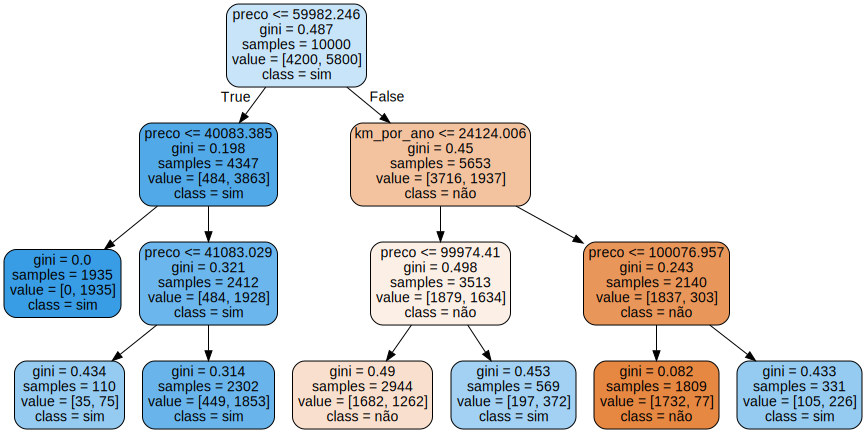

In [52]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(
    melhor, 
    out_file=None, 
    filled=True, 
    rounded=True, 
    class_names=['não', 'sim'],
    feature_names=features
)
graph = graphviz.Source(dot_data)
graph